In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
   from google.colab import drive

   drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/My Drive/kagglex-cohort4/train.csv")
X = df.drop(columns=['price'])
y = df['price']
test=pd.read_csv("/content/drive/My Drive/kagglex-cohort4/test.csv")
data = pd.concat([X, test], axis=0)
data.set_index('id', inplace=True)

In [ ]:
# Load the data


# Identify outliers using the IQR method
def impute_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[column].median()

    # Impute outliers with the median
    df[column] = df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

def impute_outliers_with_mean(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = df[column].mean()

    # Impute outliers with the median
    df[column] = df[column].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)




In [ ]:
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes


In [ ]:
# One-hot encode the 'accident' and 'fuel_type' columns
#accident_dummies = pd.get_dummies(data['accident'], prefix='accident').astype(int)
#fuel_type_dummies = pd.get_dummies(data['fuel_type'], prefix='fuel_type').astype(int)

# Concatenate the one-hot encoded columns with the original dataset
#data = pd.concat([data, accident_dummies], axis=1)

# Drop the original 'accident' and 'fuel_type' columns
#data.drop(columns=['accident'], inplace=True)

# Display the first few rows of the updated dataset to verify changes
#data.head()


In [ ]:

import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

#brand_counts = data['brand'].value_counts()
#brands_to_group = brand_counts[brand_counts < 10].index.tolist()

# Replace these brands with 'Other'
#data['brand'] = data['brand'].apply(lambda x: 'Other' if x in brands_to_group else x)

# Extract horsepower, engine size, number of cylinders from the engine column
def extract_engine_features(engine_str):
    hp = re.search(r'(\d+\.?\d*)HP', engine_str)
    liters = re.search(r'(\d+\.?\d*)L', engine_str)
    cylinders = re.search(r'(\d+)\sCylinder', engine_str)

    hp_value = float(hp.group(1)) if hp else None
    liters_value = float(liters.group(1)) if liters else None
    cylinders_value = int(cylinders.group(1)) if cylinders else None

    return hp_value, liters_value, cylinders_value

# Apply extraction function and handle missing values
data[['horsepower', 'engine_size', 'cylinders']] = data['engine'].apply(
    lambda x: pd.Series(extract_engine_features(x))
)

# Handle missing values by filling with mean or median
data['horsepower'].fillna(data['horsepower'].mean(), inplace=True)
data['engine_size'].fillna(data['engine_size'].mean(), inplace=True)
data['cylinders'].fillna(data['cylinders'].median(), inplace=True)

# Impute outliers in 'milage' and 'model_year' columns
impute_outliers_with_median(data, 'milage')
impute_outliers_with_median(data, 'model_year')
impute_outliers_with_median(data, 'horsepower')
impute_outliers_with_median(data, 'engine_size')
impute_outliers_with_median(data, 'cylinders')


In [ ]:
# Encode categorical variables
categorical_cols = ['brand', 'model','fuel_type','transmission', 'ext_col', 'int_col']

label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

accident_dummies = pd.get_dummies(data['accident'], prefix='accident').astype(int)
data = pd.concat([data, accident_dummies], axis=1)
# Normalize continuous features
scaler = StandardScaler()
data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']] = scaler.fit_transform(
    data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']]
)

# Separate features and target variable
Xt = data.drop(columns=[ 'engine','clean_title','accident'])
# Custom split point (e.g., at row index 3)
split_point =54273

# Create training and test sets
X = Xt.iloc[:split_point]
test_data = Xt.iloc[split_point:]

X.head(),y.head()

(    brand  model  model_year    milage  fuel_type  transmission  ext_col  \
 id                                                                         
 0      14    649    0.506607  0.085262          2             2       28   
 1       4     49   -1.694202  0.206259          2            19       19   
 2      21   1803   -1.294055  0.452301          2            15      194   
 3       4   1779    1.306901 -1.454499          3            45      107   
 4      40    699    0.106460  0.870023          2            35      263   
 
     int_col  horsepower  engine_size  cylinders  \
 id                                                
 0        63    0.507154    -0.161121  -0.160454   
 1        12   -0.275734    -0.540672  -0.160454   
 2         9   -0.275734     0.370251   1.253895   
 3        28    0.089614    -0.540672  -0.160454   
 4        12   -1.319586     0.066610  -0.160454   
 
     accident_At least 1 accident or damage reported  accident_None reported  
 id           

In [ ]:
X.shape

(54273, 13)

In [ ]:
y=np.log(y)
print("\nData with log-transformed target:")
print(y)


Data with log-transformed target:
0         9.305651
1         9.017968
2         9.615805
3        11.058795
4         8.968269
           ...    
54268    10.275051
54269     8.779557
54270     9.849559
54271    12.180575
54272    10.532070
Name: price, Length: 54273, dtype: float64


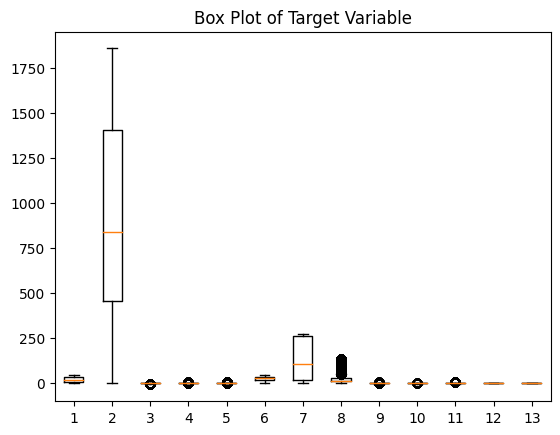

In [ ]:
plt.boxplot(X)
plt.title("Box Plot of Target Variable")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred_baseline=[y.mean()]*len(y)
mae_baseline=mean_absolute_error(y,y_pred_baseline)
mse_baseline=mean_squared_error(y,y_pred_baseline)
print( np.sqrt(mse_baseline))
print( mae_baseline)

0.8270705486270719
0.6481301630642998


In [ ]:
X.shape

(54273, 13)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

# Define input layers
input_layers = []
embedding_layers = []

# Categorical features with high cardinality
high_cardinality_features = ['brand', 'model','transmission','int_col','ext_col']

for feature in high_cardinality_features:
    input_layer = Input(shape=(1,), name=f'{feature}_input')
    input_layers.append(input_layer)
    embedding_dim = min(50, len(label_encoders[feature].classes_) // 2)
    embedding_layer = Embedding(input_dim=len(label_encoders[feature].classes_), output_dim=embedding_dim)(input_layer)
    embedding_layer = Flatten()(embedding_layer)
    embedding_layers.append(embedding_layer)

# Continuous features and other categorical features with low cardinality
other_features = [col for col in X.columns if col not in high_cardinality_features]

continuous_input = Input(shape=(len(other_features),), name='continuous_input')
input_layers.append(continuous_input)

# Concatenate all layers
concatenated = Concatenate()(embedding_layers + [continuous_input])

# Add dense layers
dense = Dense(128, activation='relu')(concatenated)
dense = Dense(64, activation='relu')(dense)
dense = Dense (32,activation='relu')(dense)
output = Dense(1)(dense)

# Define the model
model = Model(inputs=input_layers, outputs=output)

# Print the model summary
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 brand_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 model_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 transmission_input (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 int_col_input (InputLayer)  [(None, 1)]                  0         []                     

In [ ]:
from tensorflow.keras.optimizers import Adam
# Define RMSE as a custom metric
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse' ,metrics=[root_mean_squared_error,'accuracy'])

# Prepare inputs for the model
inputs = [X[feature].values for feature in high_cardinality_features] + [X[other_features].values]

# Train the model
history = model.fit(inputs, y, epochs=15, batch_size=32, validation_split=0.2,verbose=2)



Epoch 1/15
1357/1357 - 19s - loss: 14.1428 - root_mean_squared_error: 2.2839 - accuracy: 0.0000e+00 - val_loss: 0.5070 - val_root_mean_squared_error: 0.6897 - val_accuracy: 0.0000e+00 - 19s/epoch - 14ms/step
Epoch 2/15
1357/1357 - 8s - loss: 0.3865 - root_mean_squared_error: 0.6041 - accuracy: 0.0000e+00 - val_loss: 0.3375 - val_root_mean_squared_error: 0.5641 - val_accuracy: 0.0000e+00 - 8s/epoch - 6ms/step
Epoch 3/15
1357/1357 - 10s - loss: 0.2976 - root_mean_squared_error: 0.5313 - accuracy: 0.0000e+00 - val_loss: 0.2910 - val_root_mean_squared_error: 0.5240 - val_accuracy: 0.0000e+00 - 10s/epoch - 7ms/step
Epoch 4/15
1357/1357 - 9s - loss: 0.2693 - root_mean_squared_error: 0.5045 - accuracy: 0.0000e+00 - val_loss: 0.2724 - val_root_mean_squared_error: 0.5070 - val_accuracy: 0.0000e+00 - 9s/epoch - 7ms/step
Epoch 5/15
1357/1357 - 8s - loss: 0.2562 - root_mean_squared_error: 0.4926 - accuracy: 0.0000e+00 - val_loss: 0.2638 - val_root_mean_squared_error: 0.4992 - val_accuracy: 0.0000e

In [ ]:
X.describe()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,horsepower,engine_size,cylinders,accident_At least 1 accident or damage reported,accident_None reported
count,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000,54273.000000
mean,19.463914,904.355536,0.002006,0.002111,1.993017,27.760452,131.934700,27.800822,-0.000772,-0.002900,-0.002521,0.264902,0.735098
std,13.643724,552.983716,0.999977,0.998063,0.492170,11.611909,102.740384,32.162336,0.995113,0.999714,0.998633,0.441285,0.441285
min,0.000000,0.000000,-7.350244,-1.434508,0.000000,0.000000,0.000000,0.000000,-2.448957,-2.310455,-2.197811,0.000000,0.000000
25%,8.000000,456.000000,-0.551217,-0.798368,2.000000,19.000000,19.000000,12.000000,-0.677719,-0.542341,-0.177994,0.000000,0.000000
50%,16.000000,838.000000,0.164471,-0.129182,2.000000,29.000000,107.000000,12.000000,-0.026669,-0.166146,-0.177994,0.000000,1.000000
75%,32.000000,1405.000000,0.701236,0.580622,2.000000,35.000000,263.000000,28.000000,0.605233,0.661482,1.168551,1.000000,1.000000
max,48.000000,1858.000000,1.595845,6.572621,6.000000,47.000000,274.000000,132.000000,6.589148,3.520560,3.861641,1.000000,1.000000


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   brand                                            54273 non-null  int64  
 1   model                                            54273 non-null  int64  
 2   model_year                                       54273 non-null  float64
 3   milage                                           54273 non-null  float64
 4   fuel_type                                        54273 non-null  int64  
 5   transmission                                     54273 non-null  int64  
 6   ext_col                                          54273 non-null  int64  
 7   int_col                                          54273 non-null  int64  
 8   horsepower                                       54273 non-null  float64
 9   engine_size                      

In [ ]:
# Load the test set
test_data = pd.read_csv("/content/drive/My Drive/kagglex-cohort4/test.csv")
# Identify car brands with fewer than 10 instances
#brand_counts =test_data['brand'].value_counts()
#brands_to_group = brand_counts[brand_counts < 10].index.tolist()
# Replace brands in the test set with 'Other' if they are in the brands_to_group list
#test_data['brand'] = test_data['brand'].apply(lambda x: 'Other' if x in brands_to_group else x)

# Extract horsepower, engine size, number of cylinders from the engine column
test_data[['horsepower', 'engine_size', 'cylinders']] = test_data['engine'].apply(
    lambda x: pd.Series(extract_engine_features(x))
)

# Handle missing values by filling with mean or median
test_data['horsepower'].fillna(test_data['horsepower'].mean(), inplace=True)
test_data['engine_size'].fillna(test_data['engine_size'].mean(), inplace=True)
test_data['cylinders'].fillna(test_data['cylinders'].median(), inplace=True)

# One-hot encode the 'accident' and 'fuel_type' columns and convert to integers
test_accident_dummies = pd.get_dummies(test_data['accident'], prefix='accident').astype(int)
#test_fuel_type_dummies = pd.get_dummies(test_data['fuel_type'], prefix='fuel_type').astype(int)

# Concatenate the one-hot encoded columns with the original dataset
test_data = pd.concat([test_data, test_accident_dummies], axis=1)

# Drop the original 'accident' and 'fuel_type' columns
test_data.drop(columns=['accident',], inplace=True)

# Encode other categorical variables
for col in categorical_cols:
    test_data[col] = label_encoders[col].transform(test_data[col])

# Normalize continuous features
test_data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']] = scaler.transform(
    test_data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']]
)

# Separate features and id
X_test = test_data.drop(columns=['id', 'engine'])
test_ids = test_data['id']

# Prepare inputs for the model
test_inputs = [X_test[feature].values for feature in high_cardinality_features] + [X_test[other_features].values]

# Predict prices using the trained model
predicted_prices = model.predict(test_inputs)

# Combine the id and predicted prices into a dataframe
results = pd.DataFrame({'id': test_ids, 'predicted_price': np.exp(predicted_prices).flatten()})

# Save the results to a CSV file
results.to_csv('/content/drive/My Drive/kagglex-cohort4/predicted_prices2.csv' , index=False)

1131/1131 [==============================] - 3s 2ms/step


In [3]:
data=pd.read_csv("/content/drive/My Drive/kagglex-cohort4/train.csv")

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate
from keras.optimizers import Adam
import xgboost as xgb



# Identify and impute outliers in 'milage' and 'model_year' columns
def impute_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[column].median()

    df[column] = df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

impute_outliers_with_median(data, 'milage')
impute_outliers_with_median(data, 'model_year')

# Identify car brands with fewer than 10 instances
brand_counts = data['brand'].value_counts()
brands_to_group = brand_counts[brand_counts < 10].index.tolist()

# Replace these brands with 'Other'
data['brand'] = data['brand'].apply(lambda x: 'Other' if x in brands_to_group else x)

# Extract horsepower, engine size, number of cylinders from the engine column
def extract_engine_features(engine_str):
    hp = re.search(r'(\d+\.?\d*)HP', engine_str)
    liters = re.search(r'(\d+\.?\d*)L', engine_str)
    cylinders = re.search(r'(\d+)\sCylinder', engine_str)

    hp_value = float(hp.group(1)) if hp else None
    liters_value = float(liters.group(1)) if liters else None
    cylinders_value = int(cylinders.group(1)) if cylinders else None

    return hp_value, liters_value, cylinders_value

data[['horsepower', 'engine_size', 'cylinders']] = data['engine'].apply(
    lambda x: pd.Series(extract_engine_features(x))
)

# Handle missing values by filling with mean or median
data['horsepower'].fillna(data['horsepower'].mean(), inplace=True)
data['engine_size'].fillna(data['engine_size'].mean(), inplace=True)
data['cylinders'].fillna(data['cylinders'].median(), inplace=True)






In [5]:
# One-hot encode the 'accident' and 'fuel_type' columns and convert to integers
accident_dummies = pd.get_dummies(data['accident'], prefix='accident').astype(int)
data = pd.concat([data, accident_dummies], axis=1)
data.drop(columns=['accident'], inplace=True)

# Encode other categorical variables
categorical_cols = ['brand', 'model', 'transmission', 'ext_col', 'int_col', 'clean_title','fuel_type']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

# Normalize continuous features
scaler = StandardScaler()
data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']] = scaler.fit_transform(
    data[['milage', 'horsepower', 'engine_size', 'cylinders', 'model_year']]
)

# Create embeddings for high cardinality features
high_cardinality_features = ['brand', 'model','int_col','ext_col','transmission']
input_layers = []
embedding_layers = []

for feature in high_cardinality_features:
    input_layer = Input(shape=(1,), name=f'{feature}_input')
    input_layers.append(input_layer)
    embedding_dim = min(50, len(label_encoders[feature].classes_) // 2)
    embedding_layer = Embedding(input_dim=len(label_encoders[feature].classes_), output_dim=embedding_dim)(input_layer)
    embedding_layer = Flatten()(embedding_layer)
    embedding_layers.append(embedding_layer)

# Create a Keras model to get embeddings
continuous_input = Input(shape=(data.drop(columns=['id', 'engine', 'price'] + high_cardinality_features).shape[1],), name='continuous_input')
input_layers.append(continuous_input)
concatenated = Concatenate()(embedding_layers + [continuous_input])
model = Model(inputs=input_layers, outputs=concatenated)

# Prepare inputs for the model
X_high_cardinality = [data[feature].values for feature in high_cardinality_features]
X_other = data.drop(columns=['id', 'engine', 'price','clean_title'] + high_cardinality_features).values
X_inputs = X_high_cardinality + [X_other]



In [7]:
# Get embeddings
#embeddings = model.predict(X_inputs)
#X = pd.DataFrame(embeddings)

In [ ]:
# Prepare the target variable
#y = data['price']

# Train an XGBoost model
#xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
#xgb_model.fit(X, y)